In [167]:
%matplotlib inline

import os
from PIL import Image
from torch.utils.data import Dataset
import torch.utils.data as data
from torchvision import datasets, transforms, utils
import torch
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

# Definition of the path toward the train and test dataset downloaded from kaggle

The directory containing the data should be as follow: <br>
root_dir<br>
├── test <br>
│    ├── angry <br>
│    ├── disgusted<br>
│    ├── fearful<br>
│    ├── happy<br>
│    ├── neutral<br>
│    ├── sad<br>
│    └── surprised<br>
└── train<br>
&nbsp;&nbsp;&nbsp;&nbsp;├── angry<br>
&nbsp;&nbsp;&nbsp;&nbsp;├── disgusted<br>
&nbsp;&nbsp;&nbsp;&nbsp;├── fearful<br>
&nbsp;&nbsp;&nbsp;&nbsp;├── happy<br>
&nbsp;&nbsp;&nbsp;&nbsp;├── neutral<br>
&nbsp;&nbsp;&nbsp;&nbsp;├── sad<br>
&nbsp;&nbsp;&nbsp;&nbsp;└── surprised<br>

In [117]:
'''
# going to the right directory
print(os.getcwd())
os.chdir("E:\DL_data")
print(os.getcwd())

# defining the directories
root_dir = os.getcwd()
'''

# The directory structure is different in my computer
root_dir = os.path.join(os.getcwd(), "../data")
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
categories = os.listdir(train_dir)

# Illustration of the Dataset
Let's show one image for each categorie to illustrate the chosen dataset

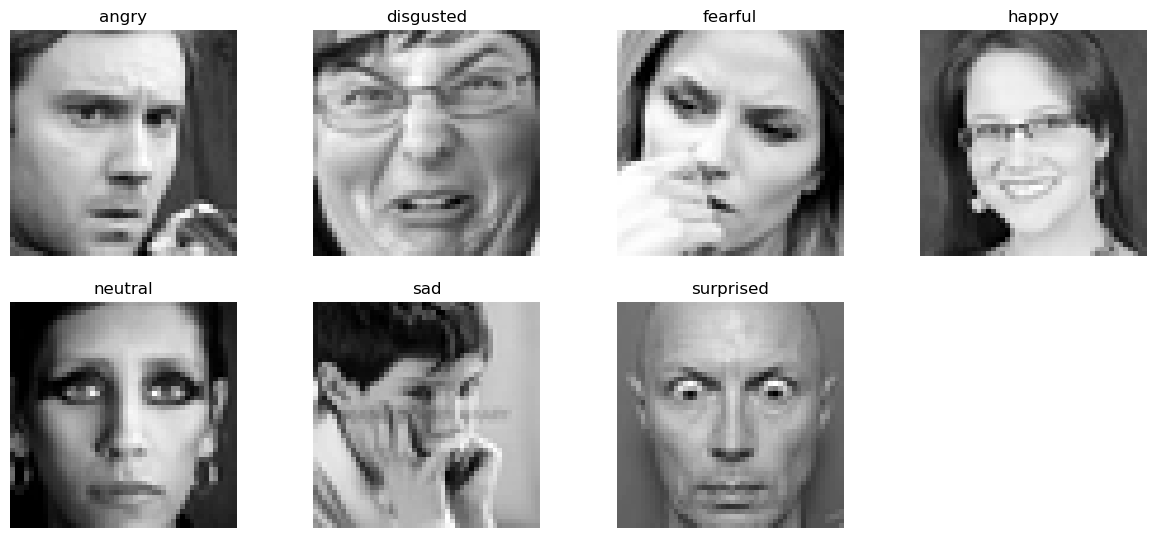

In [118]:
# Give an example of each category
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories):
    cat_path = os.path.join(train_dir, category)
    img_path = os.path.join(cat_path, os.listdir(cat_path)[0])
    img = Image.open(img_path)
    plt.subplot(3, 4, i+1)
    plt.title(category)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Exploration of the dataset

There are 28709 images in the train set for 7 categories
There are 7178 images in the test set for 7 categories


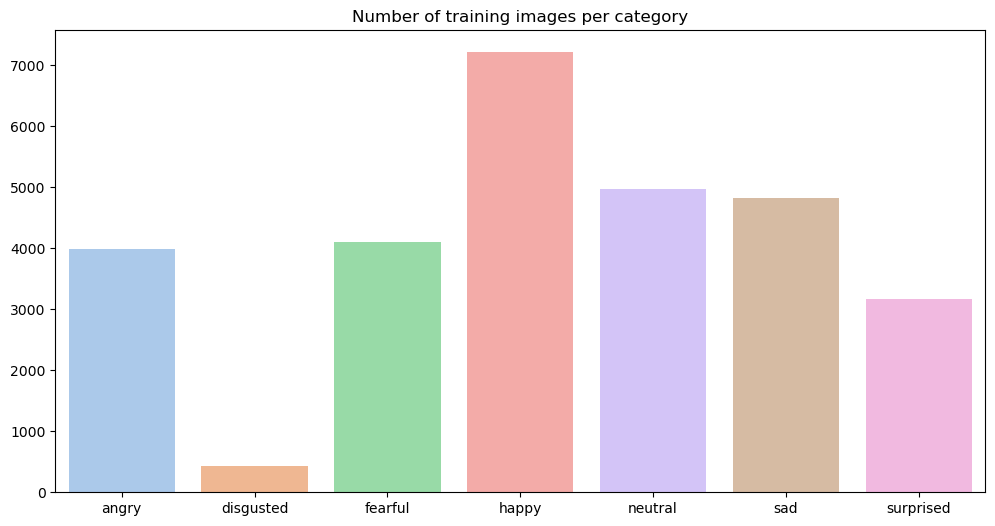

In [119]:
# counting the number of images per category in both train and test
train_counts = []
test_counts = []

for category in categories:
    train_counts.append(len(os.listdir(os.path.join(train_dir, category))))
    test_counts.append(len(os.listdir(os.path.join(test_dir, category))))

print(f"There are {sum(train_counts)} images in the train set for {len(categories)} categories")
print(f"There are {sum(test_counts)} images in the test set for {len(categories)} categories")

plt.figure(figsize=(12, 6))
plt.title('Number of training images per category')
sns.barplot(x=categories, y=train_counts, palette='pastel')
plt.show()

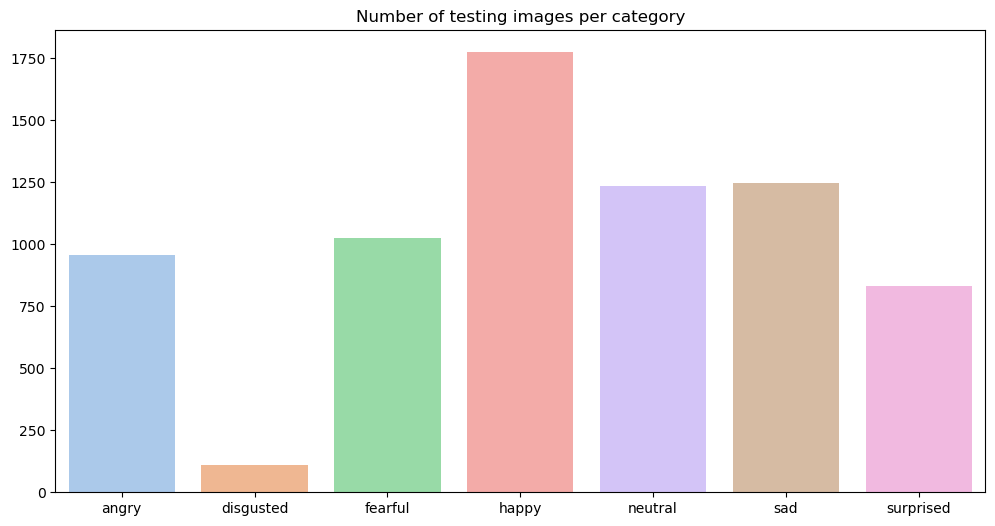

In [120]:
plt.figure(figsize=(12, 6))
plt.title('Number of testing images per category')
sns.barplot(x=categories, y=test_counts, palette='pastel')
plt.show()

We remark that the dataset is unbalenced. It will required some adaptations in the models in order to train a good model on every class

# Illustration of the differents transforms:

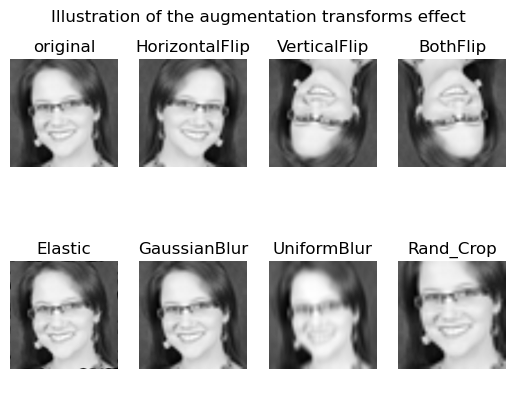

In [145]:
# Kernel size used for blurring (for the Gaussian and pepper and salt)
blur_kernel_size = 21

# Basic transform to be applied on the original image of the dataset
simple_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])
# List of the differents transform to apply to the dataset for the augmentation
transform_train = np.array([
    transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.RandomHorizontalFlip(1),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.RandomVerticalFlip(1),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.RandomHorizontalFlip(1),
        transforms.RandomVerticalFlip(1),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ElasticTransform(),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.GaussianBlur(blur_kernel_size),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Lambda(lambda l: torch.Tensor(cv2.blur(l.numpy(), (blur_kernel_size,blur_kernel_size))).view(1,300,300)),
    ]),
    transforms.Compose([
        transforms.RandomCrop((40,40)),
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
    ]),
])

# List of the name of the transform used (should be as long as transform_train)
transforms_train_name = ["HorizontalFlip","VerticalFlip","BothFlip","Elastic","GaussianBlur","UniformBlur","Rand_Crop"]


def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img), cmap = "grey")
    plt.show()

plt.title("Illustration of the augmentation transforms effect")
plt.axis("off")

for i, transform in enumerate(np.insert(transform_train, 0, simple_transform)):
    cat_path = os.path.join(train_dir, "happy")
    img_path = os.path.join(cat_path, os.listdir(cat_path)[0])
    img = Image.open(img_path)
    plt.subplot(2, 4, i+1)
    if i == 0:
        plt.title("original")
    else:
        plt.title(transforms_train_name[i-1])
    plt.imshow(transforms.functional.to_pil_image(transform(img)), cmap = "grey")
    plt.axis("off")

plt.show()


# Data augmentation
The following script will generate the augmented data and will put it into the directory pointed by output_dir


The output directory will follow the same structure with an extra validation folder structured like the folder test/train.


In [152]:
# output repository where we put the augmented dataset
output_dir = os.path.join(os.getcwd(), "../augmented_dataset")
if not os.path.isdir(output_dir):
    raise FileNotFoundError("Directory not found")


# Check if there is the relevant folder in the output directory, if not create it
if not os.path.isdir(os.path.join(output_dir,"test")):
    os.mkdir(os.path.join(output_dir,"test"))

if not os.path.isdir(os.path.join(output_dir,"train")):
    os.mkdir(os.path.join(output_dir,"train"))

if not os.path.isdir(os.path.join(output_dir,"validation")):
    os.mkdir(os.path.join(output_dir,"validation"))

for folder in ["train", "validation", "test"]:
    input = folder
    if folder == "validation":
        input = "train"

    print(f"Processing {folder} folder")        
    for category in categories:

        input_folder = os.path.join(root_dir, input, category)
        if not os.path.isdir(input_folder):
            raise FileNotFoundError(f"The category {category} is not found in {folder}")
        output_folder = os.path.join(output_dir, folder, category)
        if not os.path.isdir(output_folder):
            os.mkdir(os.path.join(output_folder))

        array = os.listdir(input_folder)

        # Split the intial dataset in train/validation datasets (while keeping class distributions)
        if folder == "train":
            array = array[:int(len(array)*0.8)]
        elif folder == "validation":
            array = array[int(len(array)*0.8):]

        print(f"Processing {category} category")
        for i, filename in enumerate(array):
            path = os.path.join(input_folder, filename)
            image = Image.open(path)

            # The transformation should only be applied on the data of the train set
            if folder == "train":
                transform = transform_train
            else:
                # Insert in a list to be iterable
                transform = [simple_transform]

            if i % 100 == 0:
                print(f"Processing image {i}")
            
            # add the original image to the train set (as the simple transform isn't in the transform_train)
            if folder == "train":
                name_of_the_image = f"{filename[:-4]}_original.png"
                try:
                    with open(os.path.join(output_folder, name_of_the_image),'xb') as f:
                        save_image(simple_transform(image), f)
                except FileExistsError:
                    pass
            
            
            for i, transf in enumerate(transform):
                # If the image already exist in the folder, do nothing
                try:
                    with open(os.path.join(output_folder, name_of_the_image),'xb') as f:
                        image_transformed = transf(image)
                        # Note don't take the 4 last caracter of the filename to not include the ".png"
                        if folder == "train":
                            name_of_the_image = f"{filename[:-4]}_{transforms_train_name[i]}.png"
                        else:
                            name_of_the_image = f"{filename[:-4]}.png"
                        
                        save_image(image_transformed, f)
                except FileExistsError:
                    pass

Processing train folder
Processing angry category
Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing image 500
Processing image 600
Processing image 700
Processing image 800
Processing image 900
Processing image 1000
Processing image 1100
Processing image 1200
Processing image 1300
Processing image 1400
Processing image 1500
Processing image 1600
Processing image 1700
Processing image 1800
Processing image 1900
Processing image 2000
Processing image 2100
Processing image 2200
Processing image 2300
Processing image 2400
Processing image 2500
Processing image 2600
Processing image 2700
Processing image 2800
Processing image 2900
Processing image 3000
Processing image 3100
Processing disgusted category
Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing fearful category
Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing imag

In [161]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, mode='train'):
        if mode != "train" and mode != 'test' and mode != "validation":
            raise AttributeError("the mode argument must be either 'train' or 'test' or 'validation'!")

        self.root_dir = root_dir # Directory where we can find train and test folder
        self.transform = transform
        self.categories = {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3,
                           'neutral': 4, 'sad': 5, 'surprised': 6} # Defines the category in order to keep track of the label
        self.images = [] # store the images path
        self.labels = [] # store the label

        # Determine train or test directory
        data_dir = os.path.join(self.root_dir, mode)
        if not os.path.isdir(data_dir):
            raise FileNotFoundError(f"Directory {data_dir} not found.")

        # Iterate over each category
        for category_name, category_id in self.categories.items():
            category_dir = os.path.join(data_dir, category_name)
            if not os.path.isdir(category_dir):
                raise FileNotFoundError(f"Directory {category_dir} not found.")

            # Iterate over images in the category directory
            for filename in os.listdir(category_dir):
                image_path = os.path.join(category_dir, filename)
                self.images.append(image_path)
                self.labels.append(category_id)

    def __len__(self):
        # return the number of the images depending on the self.mode
        return len(self.images)

    def __getitem__(self, idx):
        # retrieve image and label for idx
        image_path = self.images[idx]
        label = self.labels[idx]

        # open image
        image = Image.open(image_path)

        # if not in gray mode, convert it
        if image.mode != 'L':
            image = image.convert('L')

        return image, label

In [171]:
# Let's try to instantiate a dataset and a dataloader
train_set = EmotionDataset(os.path.join(os.getcwd(), "../augmented_dataset"), mode='train')
validation_set = EmotionDataset(os.path.join(os.getcwd(), "../augmented_dataset"), mode="validation")
test_set = EmotionDataset(os.path.join(os.getcwd(), "../augmented_dataset"), mode='test')
print(f"length of train_set {len(train_set)}, length of validation_set {len(validation_set)}, length of test_set {len(test_set)}")

train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers = 3)
validation_loader = data.DataLoader(validation_set, batch_size=32, shuffle=False)
test_loader = data.DataLoader(test_set, batch_size=32, shuffle=False)
print(f"length of train_loader {len(train_loader)}, length of validation_loader {len(validation_loader)}, length of test_loader {len(test_loader)}")
# length of train_loader {len(train_loader)}
# 21m14s de run


length of train_set 183720,length of validation_set 5694, length of test_set 7138
length of train_loader 5742,length of validation_loader 178, length of test_loader 224
